<a href="https://colab.research.google.com/github/sramirez/FeuerFreiKiller/blob/master/notebooks/FeuerFrei_Classification_DeepLearning_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Fire detector in sounds

# Fire detector in sounds

In this notebook, we aim at detecting fire in sounds which mix it with other nature sounds, and others where fire is not present. Fire is present in 1/3 images read from our dataset. 

Spectogram images comes from .wav sounds collected from youtube videos (see other notebooks in this repo). Labeling process comes from Google AudioSet (https://research.google.com/audioset/dataset/index.html).

Already preprocessed image data is collected from personal GDrive, and then data will feed a ResNet deep neural network which will be in charge of binary prediction.

I named this project "Feuer Frei" ("fire at will") in honor to the fascinating Rammstein's single equally named.

# Imports

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.io import wavfile as wav
# from scipy.fftpack import fft
import numpy as np
import os
import librosa
from pathlib import Path
from tqdm import tqdm
import glob
import IPython

# Read data from GDrive

In [9]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
image_path = Path("./drive/My Drive/datasets/image_nature_spectograms/")
label_path = Path("./drive/My Drive/datasets/label_audioset.csv")

In [11]:
Path("./drive/My Drive/datasets/").ls()

[PosixPath('drive/My Drive/datasets/google_nature_spectogram.zip'),
 PosixPath('drive/My Drive/datasets/firewind_dataset_links.csv'),
 PosixPath('drive/My Drive/datasets/image_nature_spectograms'),
 PosixPath('drive/My Drive/datasets/label_audioset.csv'),
 PosixPath('drive/My Drive/datasets/models')]

In [12]:
fnames = get_image_files(image_path)
fnames[:5]

[PosixPath('drive/My Drive/datasets/image_nature_spectograms/ZHVW7gW5Dos.png'),
 PosixPath('drive/My Drive/datasets/image_nature_spectograms/9CCRS3MCwXI.png'),
 PosixPath('drive/My Drive/datasets/image_nature_spectograms/i2ljyykygKM.png'),
 PosixPath('drive/My Drive/datasets/image_nature_spectograms/Kc4xrWpOrUM.png'),
 PosixPath('drive/My Drive/datasets/image_nature_spectograms/rnFbBItICj4.png')]

In [13]:
labels = pd.read_csv("./drive/My Drive/datasets/label_audioset.csv")
labels.head()

,id,label
0,0o4vHYlTPBA,0
1,0ogrLUe_WSY,0
2,0rcgzQpsWYs,1
3,11-d3rWQxZY,1
4,1OM5619KGEI,0


In [14]:
labels.label.value_counts()

0    3059
1    1332
Name: label, dtype: int64

In [0]:
assert(labels[labels.label == 1].shape[0] == 1332)

## Ingest data for DL

In [16]:
data = ImageDataBunch.from_csv(image_path.parent,
                               image_path.name, #ds_tfms=get_transforms(),
                              csv_labels = label_path.name, suffix='.png' ,size=224)
data.normalize(imagenet_stats)



ImageDataBunch;

Train: LabelList (3513 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,1,1,0
Path: drive/My Drive/datasets;

Valid: LabelList (878 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,0,1,0,1
Path: drive/My Drive/datasets;

Test: None

In [17]:
data.train_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f8b90e76470>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7f8b9d677ae8>, mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), do_x=True, do_y=False)], collate_fn=<function data_collate at 0x7f8ba00d3488>)

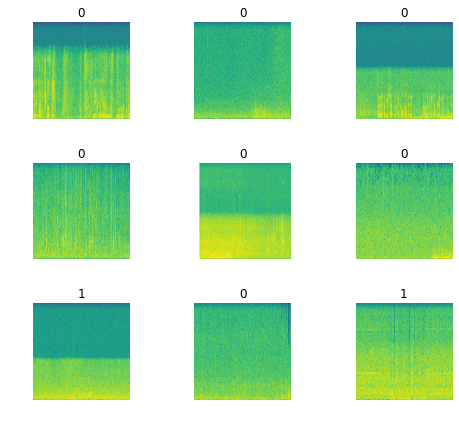

In [18]:
data.show_batch(rows=3, figsize=(7,6))

In [19]:
#Only 2 classes, as expected
print(data.classes)
len(data.classes),data.c

[0, 1]


(2, 2)

# Model time!

## Soft start: ResNet34

In [0]:
from fastai.vision import models
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy])


In [0]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.758395,0.659671,0.316629,0.683371,00:34
1,0.657912,0.561051,0.276765,0.723235,00:34
2,0.579921,0.564382,0.275626,0.724374,00:34
3,0.481292,0.549983,0.267654,0.732346,00:34


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


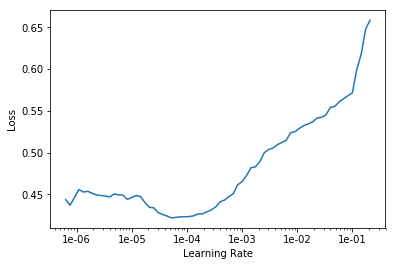

In [33]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [34]:
right_lr = 1e-5*5
left_lr = right_lr / 10
learn.fit_one_cycle(5, max_lr=slice(left_lr, right_lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.405345,0.549679,0.272210,0.727790,00:39
1,0.386181,0.562003,0.271071,0.728929,00:39
2,0.306663,0.585139,0.279043,0.720957,00:39
3,0.241069,0.593935,0.274487,0.725513,00:39
4,0.194447,0.597456,0.281321,0.718679,00:39


In [0]:
learn.save('unfreeze_0001_1e4_v2')

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy])
learn.load('unfreeze_0001_1e4')

In [28]:
learn.validate(learn.data.valid_dl)

[0.6433506, tensor(0.3622), tensor(0.6378)]

# Model interpretation

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [29]:
interp.data

ImageDataBunch;

Train: LabelList (3513 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,0,0,1
Path: drive/My Drive/datasets;

Valid: LabelList (878 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,0,0,1,0
Path: drive/My Drive/datasets;

Test: None

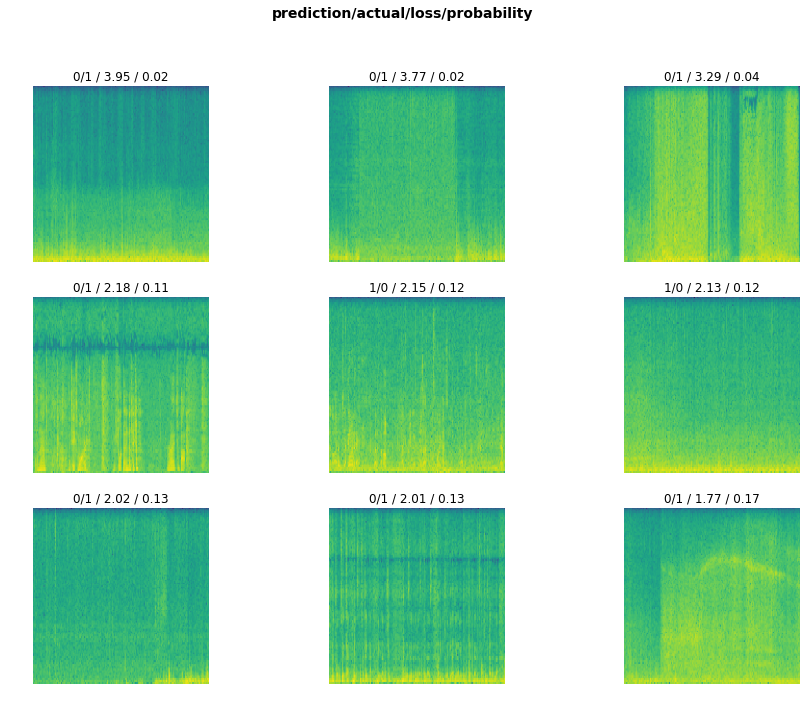

In [30]:
interp.plot_top_losses(9, figsize=(15,11))

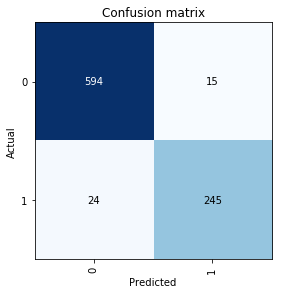

In [31]:
interp.plot_confusion_matrix()

In [32]:
learn.data.valid_ds.items[582] # in order to know the filename for top-1 loss

'drive/My Drive/datasets/image_nature_spectograms/X2GcOna2W5o.png'

In [0]:
learn.data.valid_ds.items[173]

'drive/My Drive/datasets/image_nature_spectograms/oD1-G6gNZnM.png'

In [0]:
labels.iloc[582]

id       3fZ7AC7Zf7c
label              0
Name: 582, dtype: object

In [33]:
interp.top_losses(10)

torch.return_types.topk(values=tensor([3.9512, 3.7667, 3.2915, 2.1779, 2.1546, 2.1253, 2.0234, 2.0147, 1.7712,
        1.6282]), indices=tensor([673, 591, 811, 766, 263, 132, 392, 267, 108, 364]))

The model is skewed to false negatives than false positives. According to AudioSet webpage,
quality of data is around 66% which gives some sense to the bad results here. In fire detection, false negatives should be more relevant than the other type.

In [34]:
# Baseline
labels.label.value_counts() / labels.shape[0] # then, baseline accuracy is equal to 0.6966 (random guess) 

0    0.696652
1    0.303348
Name: label, dtype: float64

# Resnet 50

In [0]:
data_32 = ImageDataBunch.from_csv(image_path.parent,
                               image_path.name,#ds_tfms=get_transforms(),
                              csv_labels = label_path.name, suffix='.png' ,size=224, bs=64)
data_32.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (3513 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,0,0,1
Path: drive/My Drive/datasets;

Valid: LabelList (878 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,1,1,0
Path: drive/My Drive/datasets;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


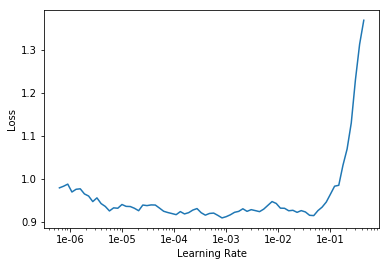

In [0]:
from fastai.vision import models
learn_32 = cnn_learner(data_32, models.resnet50, metrics=[error_rate, accuracy])
learn.lr_find()
learn.recorder.plot()

In [0]:
learn_32.fit_one_cycle(4, 1e-7)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.930836,0.784640,0.427107,0.572893,01:05
1,0.913472,0.806364,0.441913,0.558087,01:05
2,0.956107,0.782687,0.436219,0.563781,01:05
3,0.922314,0.796780,0.424829,0.575171,01:05


# Improve performance by subsampling original dataset with NN

Because quality of fire sounds is quite bad according to the Google Audioset website. We can leverage NN to select those sounds correctly classified in this first stage to train a new NN with even less instances, but with higher quality.
In this new iteration, we will create a different validation set to avoid providing a biased and very specific model.


In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy])
learn.load('unfreeze_0001_1e4_v2')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

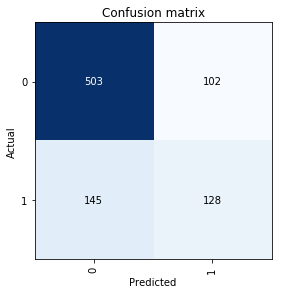

In [42]:
interp.plot_confusion_matrix()

In [60]:
len(data.valid_ds)

878

In [62]:
good_indices = []

for i in range(0, len(data.valid_ds)):
  if(learn.predict(data.valid_ds[i][0])[0] == data.valid_ds[i][1]):
    good_indices.append(i)

print(good_indices)

[1, 2, 3, 5, 7, 8, 10, 12, 13, 16, 18, 20, 21, 22, 23, 24, 25, 27, 29, 30, 31, 32, 33, 34, 36, 37, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 59, 60, 61, 63, 65, 67, 68, 69, 70, 72, 73, 74, 75, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 91, 93, 94, 95, 96, 97, 99, 101, 103, 105, 106, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120, 122, 123, 125, 128, 129, 130, 131, 132, 133, 135, 136, 141, 143, 145, 146, 147, 148, 150, 151, 152, 155, 157, 158, 159, 162, 163, 164, 165, 167, 168, 169, 171, 172, 174, 177, 178, 182, 183, 184, 186, 188, 189, 190, 191, 193, 194, 195, 196, 198, 199, 200, 201, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 218, 220, 221, 222, 224, 226, 227, 229, 230, 233, 235, 236, 239, 240, 241, 242, 243, 244, 246, 248, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 266, 267, 268, 269, 270, 271, 272, 274, 275, 281, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294, 296, 300, 301, 302, 305, 307, 308, 309, 310,

In [0]:
#imagepaths_subsample = [os.path.basename(data.valid_ds.items[i]).split('.')[0] for i in good_indices]
imagepaths_subsample = [data.valid_ds.items[i] for i in good_indices]
categories_subsample = [data.valid_ds[i][1] for i in good_indices]

In [0]:
subsample = pd.DataFrame(dict(id=imagepaths_subsample, label=categories_subsample))

In [107]:
subsample.head()

,id,label
0,drive/My Drive/datasets/image_nature_spectogra...,0
1,drive/My Drive/datasets/image_nature_spectogra...,1
2,drive/My Drive/datasets/image_nature_spectogra...,0
3,drive/My Drive/datasets/image_nature_spectogra...,0
4,drive/My Drive/datasets/image_nature_spectogra...,0


In [135]:
subsample.label.value_counts()

0    503
1    128
Name: label, dtype: int64

In [100]:
subsample.iloc[1].id

'xeqgq8zL1so'

In [0]:
subsample.to_csv("subsample.csv")

We are gonna try just with samples from validation set, only 631 examples.


In [0]:
subsample.label.astype(str)

In [0]:
sublabel_path = Path("./drive/My Drive/datasets/label_audioset.csv")

In [136]:
sub_data = ImageDataBunch.from_lists(image_path.parent,
                               fnames = subsample.id, #ds_tfms=get_transforms(),
                              labels = subsample.label.astype(str) ,size=224, valid_pct = 0.3)
sub_data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (442 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,1,0,0,0
Path: drive/My Drive/datasets;

Valid: LabelList (189 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,0,0,0,0
Path: drive/My Drive/datasets;

Test: None

In [202]:
# Check percentage of fire images
pd.Series([sub_data.valid_ds[i][1] for i in range(0, len(sub_data.valid_ds))]).value_counts() / len(sub_data.valid_ds)

0    0.767196
1    0.232804
dtype: float64

In [118]:
#Only 2 classes, as expected
print(sub_data.classes)
len(sub_data.classes)

['0', '1']


2

# Train with sampled data



In [0]:
from fastai.vision import models
learn_sampled = cnn_learner(sub_data, models.resnet34, metrics=[error_rate, accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


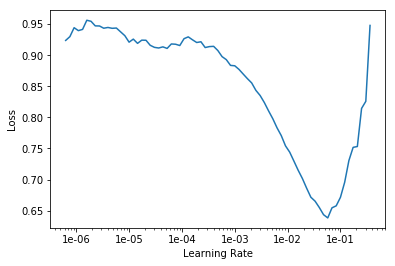

In [200]:
learn_sampled.lr_find()
learn_sampled.recorder.plot()

In [204]:
learn_sampled.fit_one_cycle(4, 1e-3*5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.406604,0.810496,0.206349,0.793651,00:05
1,0.340607,0.733113,0.206349,0.793651,00:05
2,0.299101,0.502378,0.190476,0.809524,00:05
3,0.253277,0.434883,0.190476,0.809524,00:05


So, yes it seems easier for the algorithm those sounds with higher quality. The good thing, it also applies to validation set, not only for training.



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


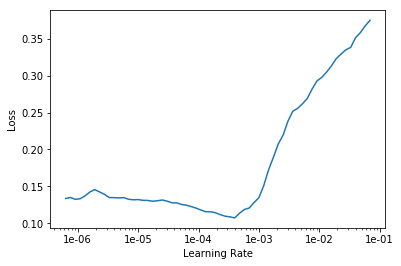

In [205]:
learn_sampled.unfreeze()
learn_sampled.lr_find()
learn_sampled.recorder.plot()

In [206]:
right_lr = 1e-4*5
left_lr = right_lr / 10
learn_sampled.fit_one_cycle(5, max_lr=slice(left_lr, right_lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.190807,0.451352,0.201058,0.798942,00:06
1,0.173114,0.865237,0.275132,0.724868,00:06
2,0.151535,1.022562,0.243386,0.756614,00:06
3,0.136521,0.551049,0.179894,0.820106,00:06
4,0.112919,0.501530,0.185185,0.814815,00:06


In [207]:
right_lr = 1e-4*7
left_lr = right_lr / 10
learn_sampled.fit_one_cycle(4, max_lr=slice(left_lr, right_lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.060007,0.392960,0.153439,0.846561,00:06
1,0.059283,0.711298,0.195767,0.804233,00:06
2,0.060593,0.719919,0.206349,0.793651,00:06
3,0.064529,0.629050,0.179894,0.820106,00:06


Nice!! Close to 85% percent of accuracy (baseline: 76%). Model is ready to be in production, though it can be improved with data better labeled.




In [0]:
learn_sampled.save("subsampled_model_unfrozen_v2")

# Model interpretation for subsampled model



In [0]:
interp_sub = ClassificationInterpretation.from_learner(learn_sampled)

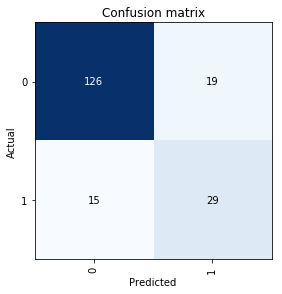

In [209]:
interp_sub.plot_confusion_matrix()

In [210]:
learn_sampled.validate(learn_sampled.data.valid_dl)

[0.62905043, tensor(0.1799), tensor(0.8201)]

In [212]:
cm = interp_sub.confusion_matrix()
cm

array([[126,  19],
       [ 15,  29]])

In [213]:
acc = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
acc 

0.8201058201058201

In [214]:
recall = cm[0][0] / (cm[0][0] + cm[0][1])
recall 

0.8689655172413793

In [215]:
spec = cm[1][1] / (cm[1][1] + cm[1][0])
spec 

0.6590909090909091

Recall and specificity are quite good, but from my point of view spec should be as high as possible, because in fire detection, false negatives are more harmful than others.
